In [ ]:
DBFILE="allblocks-istanbul-crux-docker-1s-gas20mio.db"
NAME_PREFIX="istanbul-crux-docker-1s-gas20mio"

# analyze `....db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-....db` database (created by `blocksDB_create.py`) containing all the blocks.

In this specific case the "Quorum" client of the EEA, and the `IBFT` variant, with varying gasLimit.

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://gitlab.com/electronDLT/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer1000'>10000 TPS shot at the Quorum-Istanbul node</a>
# my own experiment: 
## 10000 transactions submitted with `chainhammer` 


    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

Reading blocks table from allblocks-istanbul-crux-docker-1s-gas20mio.db


### TODO: refactoring
all the following functions could go into a separate `blocksDB_diagramming.py` for better recycling.

**For now, please simply scroll down.**

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 154 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 153)] 


In [ ]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 154


In [ ]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 153.


<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 42717
txcount_max 303
txcount_av 129.87662337662337
txcount_sum 20001
blocks_nonempty_count 75
av tx per nonempty blocks =  266.68


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### `geth` based clients have a nanosecond timestamp

not anymore?

In [ ]:
# transform nanoseconds to seconds
# df["timestamp"]=df["timestamp"]/1000000000
df[0:10]


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,1533565005,698,0,20000000,0
1,1,1534423264,902,0,20004881,0
2,2,1534423265,902,0,20009764,0
3,3,1534423266,902,0,20014648,0
4,4,1534423267,902,0,20019533,0
5,5,1534423268,902,0,20024419,0
6,6,1534423269,902,0,20029306,0
7,7,1534423270,902,0,20034194,0
8,8,1534423271,902,0,20039084,0
9,9,1534423272,902,0,20043975,0


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)


In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
29,29,1534423292,42717,8087373,20142043,303,1.0,303.0,239.666667,144.0,72.0,8087373.0,6401943.0,3866600.4,20142043.0,2.013713e+07,20132215.6
28,28,1534423291,42561,8087373,20137128,303,1.0,303.0,138.666667,83.4,41.7,8087373.0,3706152.0,2249125.8,20137128.0,2.013221e+07,20127303.2
68,68,1534423331,42025,7953918,20334658,298,1.0,298.0,280.000000,276.8,275.2,7953918.0,7473480.0,7388068.8,20334658.0,2.032970e+07,20324736.6
76,76,1534423339,41475,7847154,20374396,294,1.0,294.0,285.333333,276.0,278.1,7847154.0,7615832.0,7366716.0,20374396.0,2.036942e+07,20364455.2
67,67,1534423330,40919,7740390,20329696,290,1.0,290.0,268.666667,271.6,272.7,7740390.0,7170982.0,7249275.6,20329696.0,2.032474e+07,20319777.2
48,48,1534423311,40923,7740390,20235652,290,1.0,290.0,276.666667,274.6,271.8,7740390.0,7384510.0,7329348.6,20235652.0,2.023071e+07,20225779.2
96,96,1534423359,40648,7687008,20474082,288,1.0,288.0,279.666667,277.6,273.6,7687008.0,7464583.0,7409421.6,20474082.0,2.046909e+07,20464092.6
83,83,1534423346,40511,7660317,20409231,287,1.0,287.0,275.333333,276.6,276.5,7660317.0,7348922.0,7382730.6,20409231.0,2.040425e+07,20399273.2
94,94,1534423357,40510,7660317,20464091,287,1.0,287.0,278.666667,273.8,273.1,7660317.0,7437892.0,7307995.8,20464091.0,2.045910e+07,20454107.0
72,72,1534423335,40506,7660317,20354517,287,1.0,287.0,282.666667,279.6,275.6,7660317.0,7544656.0,7462803.6,20354517.0,2.034955e+07,20344586.2


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
37,37,1534423300,36095,6806205,20181404,255,1.0,255.0,270.333333,273.0,278.6,6806205.0,7215467.0,7286643.0,20181404.0,2.017648e+07,20171558.0
76,76,1534423339,41475,7847154,20374396,294,1.0,294.0,285.333333,276.0,278.1,7847154.0,7615832.0,7366716.0,20374396.0,2.036942e+07,20364455.2
83,83,1534423346,40511,7660317,20409231,287,1.0,287.0,275.333333,276.6,276.5,7660317.0,7348922.0,7382730.6,20409231.0,2.040425e+07,20399273.2
38,38,1534423301,39130,7393407,20186330,277,1.0,277.0,272.333333,274.8,276.0,7393407.0,7268849.0,7334686.8,20186330.0,2.018140e+07,20176481.2
84,84,1534423347,38165,7206570,20414212,270,1.0,270.0,280.000000,274.2,275.9,7206570.0,7473480.0,7318672.2,20414212.0,2.040923e+07,20404252.0
50,50,1534423313,38303,7233261,20245531,271,1.0,271.0,278.666667,275.2,275.6,7233261.0,7437892.0,7345363.2,20245531.0,2.024059e+07,20235653.2
72,72,1534423335,40506,7660317,20354517,287,1.0,287.0,282.666667,279.6,275.6,7660317.0,7544656.0,7462803.6,20354517.0,2.034955e+07,20344586.2
68,68,1534423331,42025,7953918,20334658,298,1.0,298.0,280.000000,276.8,275.2,7953918.0,7473480.0,7388068.8,20334658.0,2.032970e+07,20324736.6
85,85,1534423348,39130,7393407,20419194,277,1.0,277.0,278.000000,274.6,275.0,7393407.0,7420098.0,7329348.6,20419194.0,2.041421e+07,20409232.0
56,56,1534423319,38163,7206570,20275196,270,1.0,270.0,276.666667,276.0,274.9,7206570.0,7384510.0,7366716.0,20275196.0,2.027025e+07,20265304.0


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>whole chain</a>


/home/akrueger/Documents/Code/envs/py3eth/lib/python3.5/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


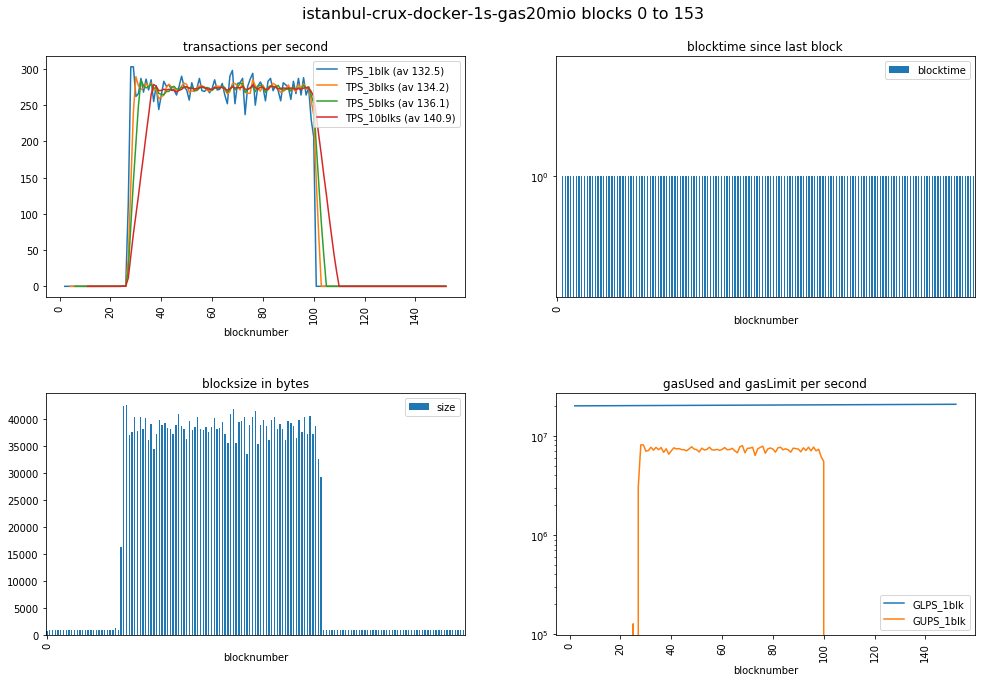

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

<a id='experiment1'>zoom in on one experiment</a>

# final experiment ...


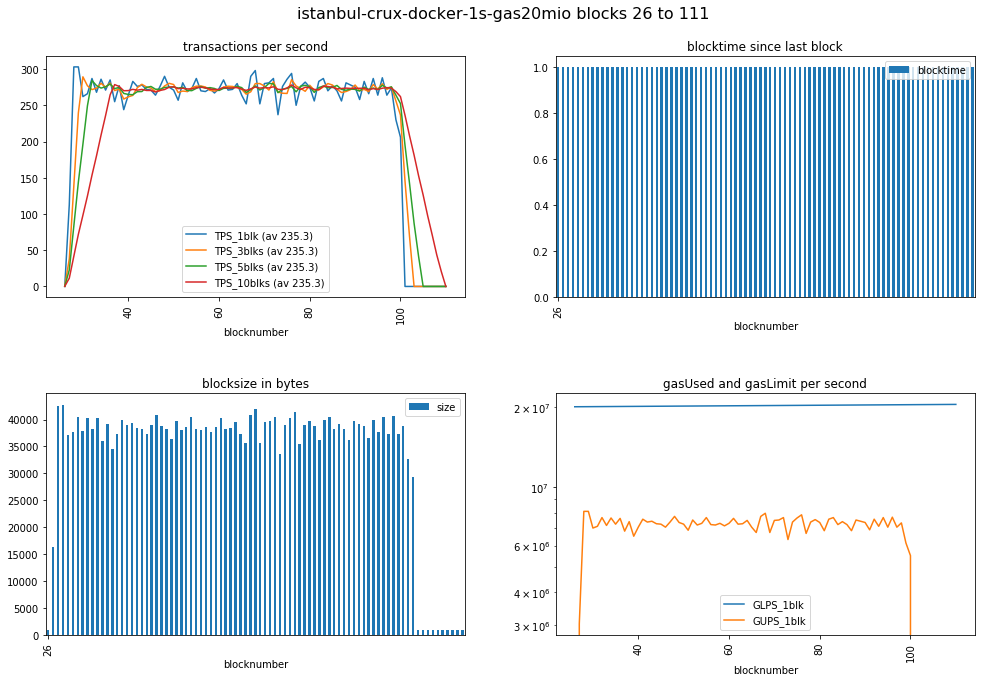

In [ ]:
# starting only at block xx because the waiting time before experiment start

diagrams(df, 26, 111, NAME_PREFIX, gas_logy=True, bt_logy=False)